<a href="https://colab.research.google.com/github/alvaroguarda/Sistema-reconhecimento-facial/blob/main/Sistema_reconhecimento_facial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
from mtcnn.mtcnn import MTCNN
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
detector = MTCNN()

In [ ]:
weights_path = '/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
data_path = 'drive/MyDrive/FaceRecognition/images/Cleaned Dataset'

In [ ]:
# Set the image size, number of channels, batch size, and number of epochs
img_size = (224, 224)
channels = 3
batch_size = 32
epochs = 13

In [ ]:
#Display image
def display(img, neww, frameName="Image"):
    h, w = img.shape[0:2]
    newh = int(neww*(h/w))
    img = cv2.resize(img, (neww, newh))
    cv2_imshow(img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

In [ ]:
# Function to detect faces in an image
def detect_faces(image_path):
    """
    Detects faces in an image and draws rectangles around them.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray or None: The image with rectangles drawn around faces,
                                 or None if the image could not be read.
        list: List of detected face coordinates. Element: [x, y, w, h].
    """
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image file {image_path}")
        return None

    # Detect faces in the image
    faces_rect = detector.detect_faces(img)

    return img, faces_rect

In [ ]:
# Create a dictionary that maps each character to the number of images
char_dict = {}
for char in os.listdir(data_path):
    char_dict[char] = len(os.listdir(os.path.join(data_path, char)))
print(char_dict)

{'raj': 70, 'sheldon': 176, 'howard': 68, 'leonard': 23}


In [ ]:
# Create an ImageDataGenerator for data augmentation and set its parameters
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

# Create a generator for the training data
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# Create a generator for the validation data
validation_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 271 images belonging to 4 classes.
Found 66 images belonging to 4 classes.


In [ ]:
# Get the number of classes from the training generator
num_classes = train_generator.num_classes
print(train_generator.class_indices)

{'howard': 0, 'leonard': 1, 'raj': 2, 'sheldon': 3}


In [ ]:
# Define a function to create the VGG16 model with additional layers
def prepare_model(num_classes):
    model = Sequential()
    model.add(VGG16(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], channels)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [ ]:
# Create the model
model = prepare_model(num_classes)
print(model.summary())
#print(model._get_trainable_state())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
# Train the model on the training and validation data
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 215s 26s/step - accuracy: 0.3713 - loss: 2.1076 - val_accuracy: 0.5781 - val_loss: 1.0342
Epoch 2/13
1/8 ━━━━━━━━━━━━━━━━━━━━ 2:04 18s/step - accuracy: 0.4688 - loss: 1.2082

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.4688 - loss: 1.2082 - val_accuracy: 0.6562 - val_loss: 1.0259
Epoch 3/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 224s 22s/step - accuracy: 0.6418 - loss: 1.1112 - val_accuracy: 0.7656 - val_loss: 0.6998
Epoch 4/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.9375 - loss: 0.2919 - val_accuracy: 0.6719 - val_loss: 0.9022
Epoch 5/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 203s 27s/step - accuracy: 0.7630 - loss: 0.7193 - val_accuracy: 0.7812 - val_loss: 0.6768
Epoch 6/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.8125 - loss: 0.6302 - val_accuracy: 0.8125 - val_loss: 0.5208
Epoch 7/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 202s 26s/step - accuracy: 0.9406 - loss: 0.2696 - val_accuracy: 0.9062 - val_loss: 0.4163
Epoch 8/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.9062 - loss: 0.3041 - val_accuracy: 0.9062 - val_loss: 0.3626
Epoch 9/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 168s 21s/step - accuracy: 0.9371 - loss: 0.1858 - val_accuracy: 0.8281 - val_loss: 0.3193
Epoch 10/13

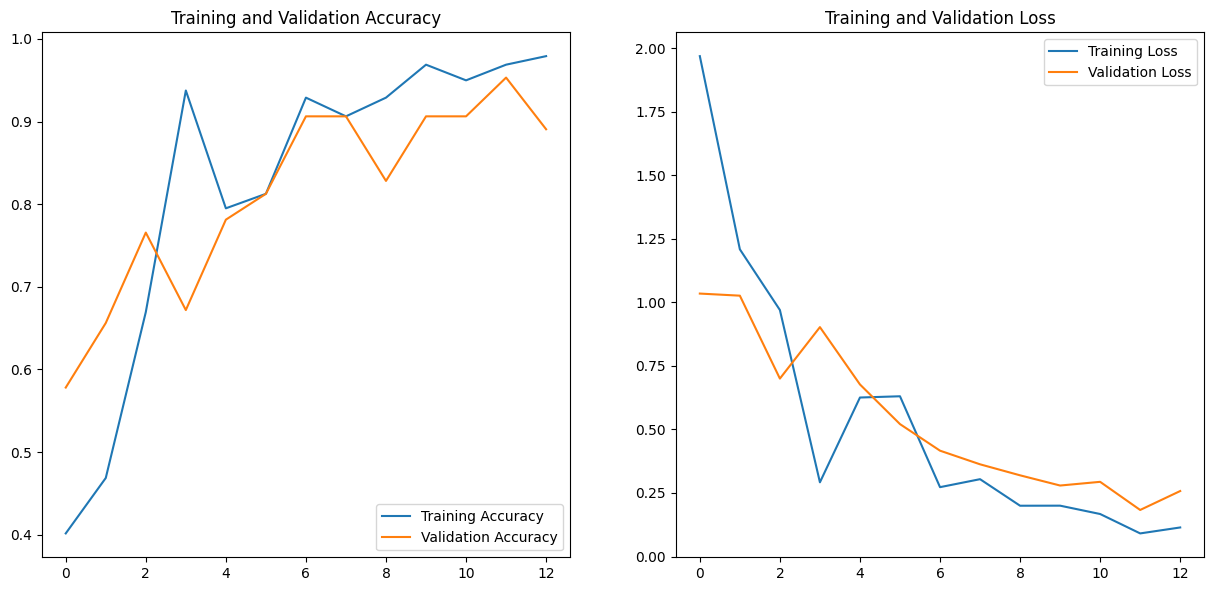

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import tensorflow as tf

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
[[4.5806044e-16 0.0000000e+00 2.0882929e-38 1.0000000e+00]]


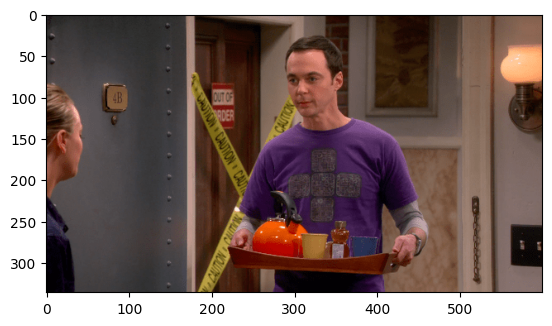

In [ ]:
image = tf.keras.utils.load_img("drive/MyDrive/FaceRecognition/images/15 _Rules_ According To Sheldon Cooper.png")
plt.imshow(image)
image = tf.keras.preprocessing.image.smart_resize(image, (224,224), interpolation='bilinear')
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
print(predictions)

In [ ]:
model.save('drive/MyDrive/FaceRecognition/finetuned_model.h5')

In [ ]:
model.save('drive/MyDrive/FaceRecognition/my_model.keras')

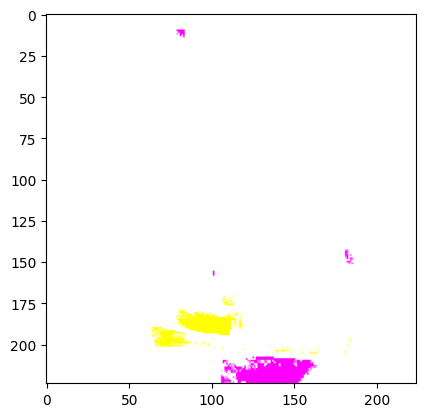

In [ ]:
plt.imshow(image)

In [ ]:
# Function to preprocess and predict the class of a new image
def predict_image(img, model, img_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    predictions = model.predict(img)
    print(predictions)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)
    return predicted_class, confidence

In [ ]:
# Plot the learning history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    return

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 1024)           │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,492,292 (13.32 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

Found 271 images belonging to 4 classes.
Found 66 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 86s 9s/step - accuracy: 0.3903 - loss: 2.3010 - val_accuracy: 0.5152 - val_loss: 1.2613
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5704 - loss: 1.1495 - val_accuracy: 0.7273 - val_loss: 1.0227


Model trained and saved as MobileNet_finetuned_model.h5


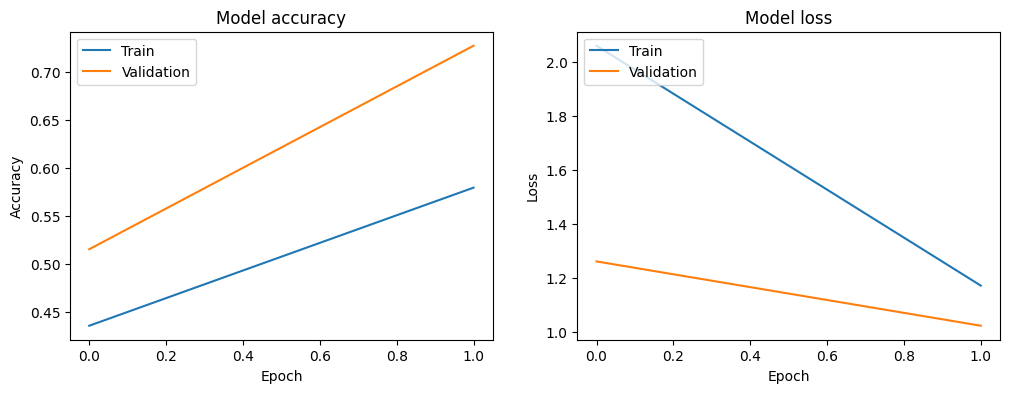

In [ ]:
# Call the learn function
data_path = 'drive/MyDrive/FaceRecognition/images/Cleaned Dataset'

# Train the model
model, history, img_size, class_name_list = learn(data_path)
# Plot training history
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
[[0.06429084 0.00845213 0.89236563 0.03489142]]
Predicted class: raj, Confidence: 89 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[[0.11802879 0.04401464 0.16643521 0.6715213 ]]
Predicted class: sheldon, Confidence: 67 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[0.00238574 0.0024009  0.02817507 0.9670382 ]]
Predicted class: sheldon, Confidence: 96 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[[0.10295815 0.00654956 0.00316428 0.88732797]]
Predicted class: sheldon, Confidence: 88 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[[5.6072958e-02 2.5754175e-03 9.0258778e-04 9.4044906e-01]]
Predicted class: sheldon, Confidence: 94 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[0.03638592 0.00254391 0.0134205  0.94764966]]
Predicted class: sheldon, Confidence: 94 %


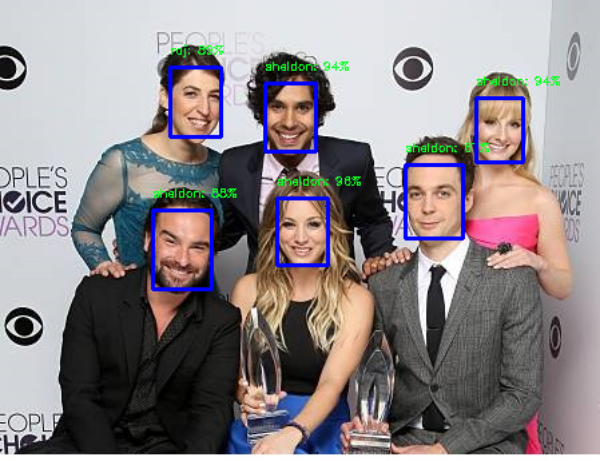

In [ ]:
# Example usage of the face detection function
test_image_path = 'drive/MyDrive/FaceRecognition/images/teste_612x612.jpg'

if os.path.exists(test_image_path):
    img, faces_rect = detect_faces(test_image_path)

    # Predict end draw rectangles around the detected faces
    #for (x, y, w, h) in faces_rect:
    for result in faces_rect:
        x, y, w, h = result['box']
        face_img = img[y:y+h, x:x+w]
        predicted_class, confidence = predict_image(face_img, model, img_size)
        confidence = int(confidence * 100)  # Convert to percentage
        print(f'Predicted class: {class_name_list[predicted_class]}, Confidence: {confidence}', '%')

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2) # Blue rectangle
        # Add class label and confidence
        label = f"{class_name_list[predicted_class]}: {confidence}%"
        if confidence < 50:
            label = f"Unknown : {confidence}"
        cv2.putText(
            img,
            text=label,
            org=(x, max(y-10, 0)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.3,
            color=(36, 255, 12),
            thickness=1
        )  # Green text

    # Display the image with detected faces
    display(img, 600, "Detected Faces")
else:
    print(f'Test image not found at {test_image_path}. Please provide a valid image path.')

In [ ]:
#------------------------------------

In [ ]:
def get_image(path):
    try:
        if os.path.getsize(path) > 0: # Check if file is not empty
          img = image.load_img(path, target_size=(224, 224))
          x = image.img_to_array(img)
          x = np.expand_dims(x, axis=0)
          x = preprocess_input(x)
          return img, x
    except Exception as e:
        print(f"Error loading image {path}: {e}")
    return None, None

In [ ]:
img_path = 'FaceRecognition/images/homem/frame_0000.jpg'

img, x = get_image(img_path)

# load image from file
pixels = plt.imread(img_path)

# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(pixels)

# # display faces on the original image
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(pixels)
# # plot each box
# for result in results:
#     x, y, width, height = result['box']
#     # create the shape
#     rect = patches.Rectangle((x, y), width, height, fill=False, color='red')
#     ax.add_patch(rect)
# plt.show()


# extract the bounding box from the first face
x1, y1, width, height = results[0]['box']
x2, y2 = x1 + width, y1 + height

# extract the face
face = pixels[y1:y2, x1:x2]
# resize pixels to the model size
image = Image.fromarray(face)
image = image.resize((224, 224))
face_array = np.asarray(image)


# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
    pixels = plt.imread(img_path)
    # create the detector, using default weights
    detector = MTCNN()
	# detect faces in the image
    results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
	# extract the face
    face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face(img_path)
# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)
# create a vggface model
model = VGGFace(model='resnet50')
# perform prediction
yhat = model.predict(samples)
# convert prediction into names
results = decode_predictions(yhat)
# display most likely results
for result in results[0]:
	print('%s: %.3f%%' % (result[0], result[1]*100))


Error loading image FaceRecognition/images/homem/frame_0000.jpg: [Errno 2] No such file or directory: 'FaceRecognition/images/homem/frame_0000.jpg'


FileNotFoundError: [Errno 2] No such file or directory: 'FaceRecognition/images/homem/frame_0000.jpg'

In [ ]:
#
def learn(data_path):
    # Define image size, batch size, and other parameters
    img_size = (224, 224)
    batch_size = 32
    num_classes = 4  # Number of classes in the dataset
    epochs = 2
    learning_rate = 0.0001
    input_shape = (224, 224, 3)
    validation_split = 0.2

    # Load the MobileNet model without the top layers and with pre-trained weights
    base_model = MobileNet(weights='imagenet', include_top=False,
                       input_shape=input_shape, pooling='max')
    base_model.trainable = False  # Freeze the base model

    # Create a new model and add layers
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    # Data augmentation and data generators
    datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
    train_generator = datagen.flow_from_directory(data_path, target_size=img_size, batch_size=batch_size, class_mode='sparse', subset='training')
    validation_generator = datagen.flow_from_directory(data_path, target_size=img_size, batch_size=batch_size, class_mode='sparse', subset='validation')

    class_name_list = list(train_generator.class_indices.keys())

    # Train the model
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)
    # Save the trained model
    model.save('drive/MyDrive/FaceRecognition/MobileNet_finetuned_model.h5')
    print('Model trained and saved as MobileNet_finetuned_model.h5')
    return model, history, img_size, class_name_list
